In [145]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA as ICA
from sklearn import random_projection as RP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import mean_squared_error as MSE
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve


import warnings
warnings.filterwarnings('ignore')

%config Completer.use_jedi = False

In [146]:
df_white = pd.read_csv("data/wine/winequality-white.csv", delimiter=";")
df_red = pd.read_csv("data/wine/winequality-red.csv", delimiter=";")

df = pd.concat([df_white, df_red], axis=0)

In [147]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [148]:
df.shape

(6497, 12)

In [149]:
# Some data is right-skewed
# df['free sulfur dioxide'] = np.log(1 + df['free sulfur dioxide'])

<AxesSubplot:xlabel='quality', ylabel='count'>

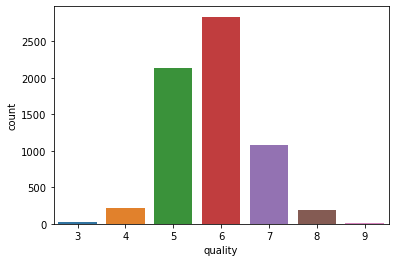

In [150]:
sns.countplot(x=df['quality'])

In [151]:
# there is a class imbalacement
# lets map quality to low, mid, high (Only 3 classes for this experiement)

quality_map = {3:0, 4:0, 5:0, 6:1, 7:2, 8:2, 9:2}
df['quality'] = df['quality'].map(quality_map)

<AxesSubplot:xlabel='quality', ylabel='count'>

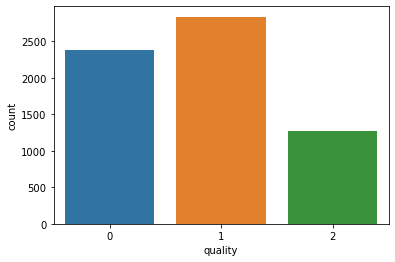

In [152]:
sns.countplot(x=df['quality'])

In [153]:
x = df.drop(columns=['quality'])
y = df['quality']

In [154]:
y.value_counts()

1    2836
0    2384
2    1277
Name: quality, dtype: int64

In [155]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=52)

In [156]:
print(f"train set size: {x_train.shape}")
print(f"test set size: {x_test.shape}")

train set size: (5197, 11)
test set size: (1300, 11)


# Scale

In [157]:
# create scaler
scaler = StandardScaler()

In [158]:
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.fit_transform(x_test)
y_train_sc = y_train
y_test_sc = y_test

In [159]:
print(np.min(x_train_sc))
print(np.max(x_train_sc))

-3.1059619593232637
15.709442085996113


### Helper Methods

In [160]:
def get_countplot(x, y, model):
    cluster = model.predict(x)
    df = pd.DataFrame(x)
    df["Cluster"] = cluster
    df["Label"] = y.values
    
    sns.countplot(data = df[["Cluster", "Label"]], x = "Cluster" , hue = "Label", linewidth=1)
    plt.show()
    
#     sns.countplot(data = df[["cluster", "label"]], x = "cluster", linewidth=1)
#     plt.show()
    

# 1) Run Clustering

- 1.1) K-means
- 1.2) EM

## 1.1) K-Means

In [161]:
def kmeans_inertia(x_train_sc):
    """
    inertia = sum_of_squared_distances
    """
    kmeans_inertia = []
    K = range(1,15)
    
    for k in K:
        km = KMeans(n_clusters=k, random_state=0)
        km = km.fit(x_train_sc)
        kmeans_inertia.append(km.inertia_)  
        
    return kmeans_inertia

In [162]:
kmeans_inertia_df = kmeans_inertia(x_train_sc)

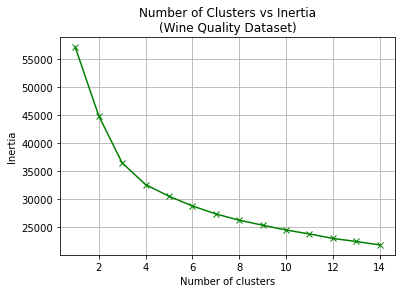

In [163]:
plt.plot(K, kmeans_inertia_df, 'x-', color='g')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Number of Clusters vs Inertia\n(Wine Quality Dataset)')

plt.grid()
plt.savefig('images/wq/1.1 Kmeans Inertia.png')
plt.show()

In [164]:
def kmeans_sil_score(x_train_sc):
    n_clusters=np.arange(2, 10)
    data=[]
    # data.append([1, 0])

    for n in n_clusters:
        km = KMeans(n, random_state=0)
        km = km.fit(x_train_sc)
        labels = km.predict(x_train_sc)
        sil = silhouette_score(x_train_sc, labels, metric='euclidean')

        data.append([n, sil])

    kmeans_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    return kmeans_sil_df

In [165]:
kmeans_sil_df = kmeans_sil_score(x_train_sc)

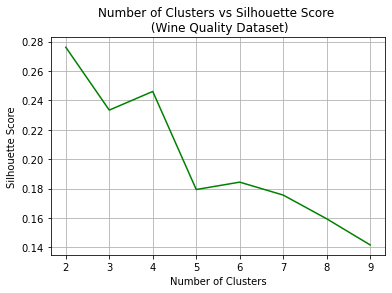

In [166]:
plt.title("Number of Clusters vs Silhouette Score \n (Wine Quality Dataset)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 
plt.plot(kmeans_sil_df["Clusters"], kmeans_sil_df["Silhouette Score"], color='g')

plt.grid()
plt.savefig('images/wq/1.1 Kmeans sil score.png')
plt.show()

In [174]:
def kmeans_pairplot(x_train_sc, y_train):
    km = KMeans(n_clusters=4, random_state=0)
    labels = km.fit_predict(x_train_sc)
    
#     plt.scatter(x_train_sc[:, 0], x_train_sc[:, 3], c=labels, s=10, cmap='viridis');

    data = pd.DataFrame(x_train_sc)
    data = data.iloc[:, :4]
    
    data["labels"] = labels
    
    sns.pairplot(data, hue="labels")
    plt.show()
    
    get_countplot(x_train_sc, y_train, km)
    
    clustering_accuracy = 1 - accuracy_score(labels, y_train)
    print(f"clustering_accuracy = {clustering_accuracy}")

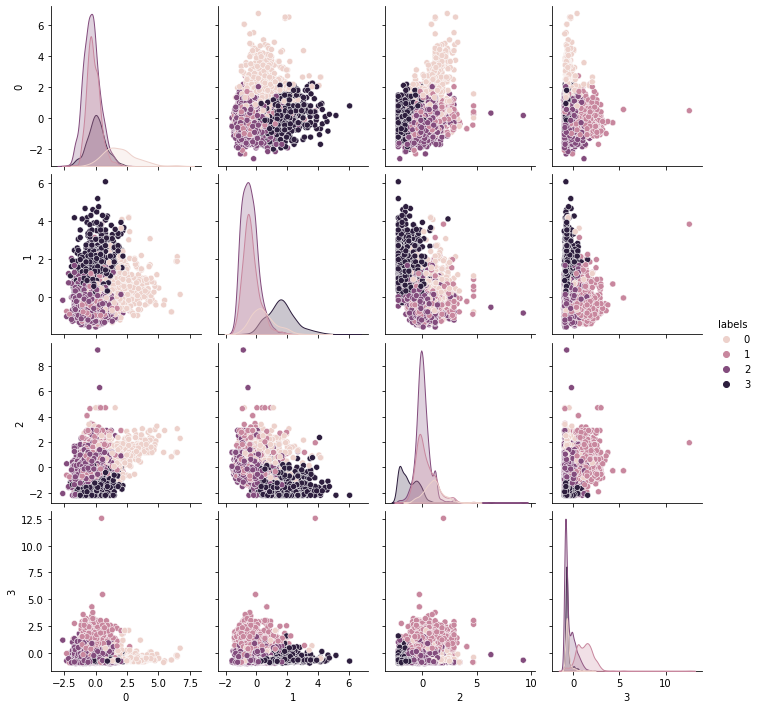

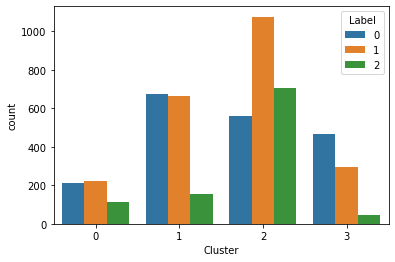

clustering_accuracy = 0.6955936116990571


In [175]:
kmeans_pairplot(x_train_sc, y_train)

## 1.2) EM

In [168]:
def em_sil_score(x_train_sc):
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_train_sc)
        labels = gmm.predict(x_train_sc)
        sil = silhouette_score(x_train_sc, labels, metric='euclidean')

        data.append([n, sil])

    em_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    return em_sil_df
    

In [169]:
em_sil_df = em_sil_score(x_train_sc)

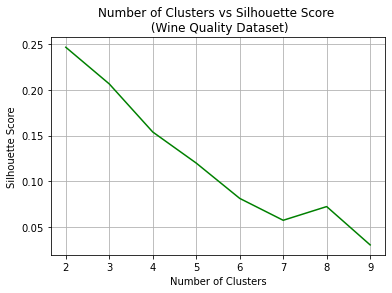

In [170]:

plt.title("Number of Clusters vs Silhouette Score \n (Wine Quality Dataset)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 
plt.plot(em_sil_df["Clusters"], em_sil_df["Silhouette Score"], color="g")

plt.grid()
plt.savefig('images/wq/1.2 EM sil score.png')
plt.show()

In [171]:
def em_bic_score(x_train_sc):
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_train_sc)
        labels = gmm.predict(x_train_sc)
        bic = gmm.bic(x_train_sc)

        data.append([n, bic])

    em_bic_df = pd.DataFrame(data, columns=["Clusters", "BIC Score"])
    return em_bic_df
    

In [172]:
em_bic_df = em_bic_score(x_train_sc)

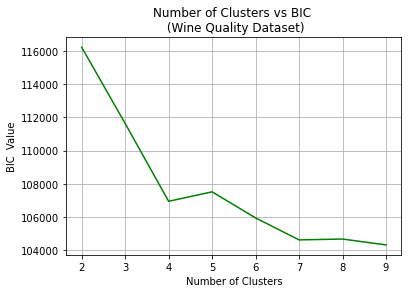

In [173]:

plt.title("Number of Clusters vs BIC \n (Wine Quality Dataset)")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC  Value") 
plt.plot(em_bic_df["Clusters"], em_bic_df["BIC Score"], color='g')

plt.grid()
plt.savefig('images/wq/1.2 EM BIC score.png')
plt.show()

In [176]:
def em_pairplot(x_train_sc, y_train):
    gmm = GaussianMixture(n_components=4, random_state=0)
    labels = gmm.fit_predict(x_train_sc)
    
#     plt.scatter(x_train_sc[:, 0], x_train_sc[:, 3], c=labels, s=10, cmap='viridis');

    data = pd.DataFrame(x_train_sc)
    data = data.iloc[:, :4]
    
    data["labels"] = labels
    
    sns.pairplot(data, hue="labels")
    plt.show()
    
    get_countplot(x_train_sc, y_train, gmm)
    
    clustering_accuracy = 1 - accuracy_score(labels, y_train)
    print(f"clustering_accuracy = {clustering_accuracy}")

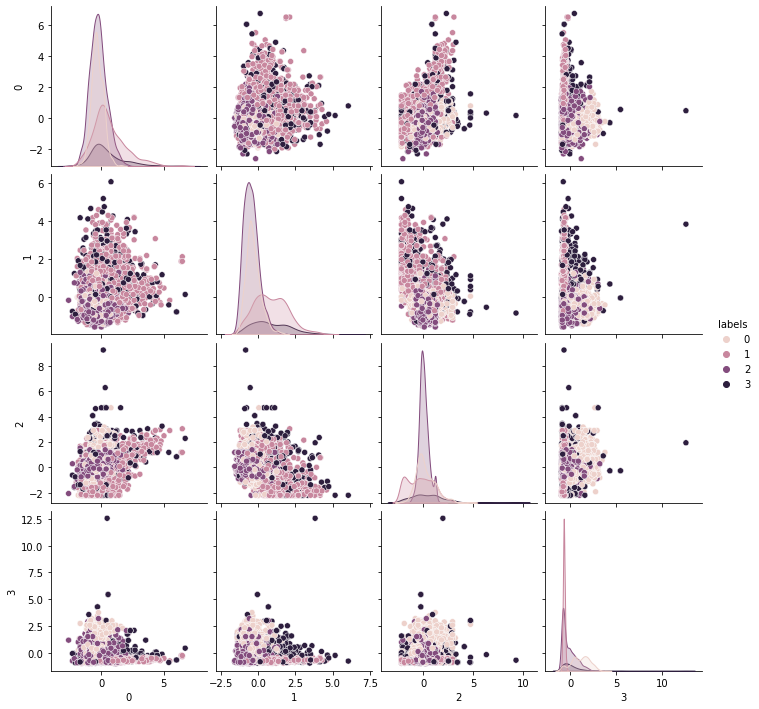

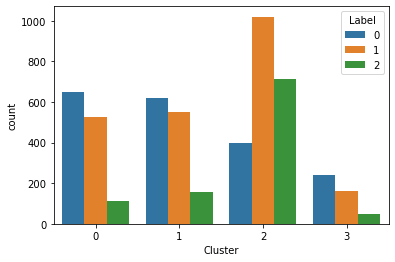

clustering_accuracy = 0.6320954396767366


In [177]:
em_pairplot(x_train_sc, y_train)

# 2) Dimensionality reduction

## 2.1) PCA

In [195]:
def pca_get_num_componenets_to_retain_variance(x_train):
    retain_variance = 0.90

    pca = PCA(retain_variance)
    principalComponents = pca.fit(x_train)

    comp_num = pca.n_components_

    print(f"{comp_num} components to retain {retain_variance} variance")

In [196]:
pca_get_num_componenets_to_retain_variance(x_train_sc)

8 components to retain 0.9 variance


In [183]:
def pca_plot_pc(x_train, y_train):
    comp_num=8
    
    pca = PCA(n_components=comp_num)
    principalComponents = pca.fit_transform(x_train)
    
    columns = []
    for i in range(comp_num):
        columns.append(f"principal component {i+1}")

    print(columns)
    
    principalDf = pd.DataFrame(data = principalComponents, columns = columns)
    
    principalDf['diagnosis'] = y_train.values
    
    
    fig = plt.figure(figsize = (8,8))

    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('PCA: Visualization')

    diagnosis = [0, 1]
    colors = ['r', 'g']

    for target, color in zip(diagnosis, colors):
        indicesToKeep = principalDf['diagnosis'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
                   , principalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 50)

        ax.legend(diagnosis)
    
#     plt.savefig('images/wq/2.1 pc1 vs pc2.png')
    ax.grid()
    
    print("Explained variation per principal component:\n")
    print(pca.explained_variance_ratio_)
    
    np.sum(pca.explained_variance_ratio_)

['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8']
Explained variation per principal component:

[0.27518541 0.22662825 0.14059715 0.08812275 0.06537384 0.05575813
 0.04754148 0.04588207]


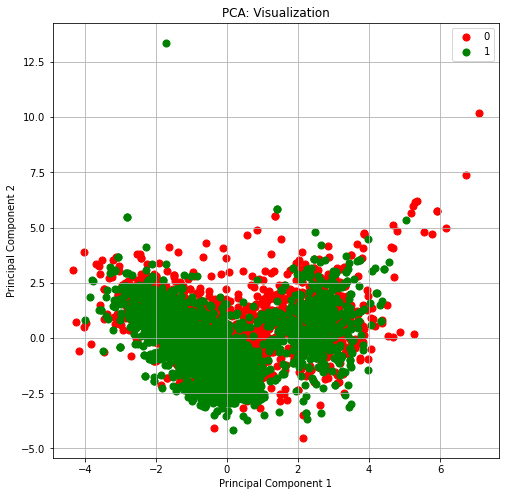

In [184]:
pca_plot_pc(x_train_sc, y_train)

In [191]:
def run_pca(x_train):
    """
    Run PCA and plot variance retained for each number of components
    """
    
    n = x_train_sc.shape[1]
    data = []
    
    for num in range(1, n+1): 
        pca = PCA(n_components=num)
        principalComponents = pca.fit_transform(x_train)
        
        variance_retained = np.sum(pca.explained_variance_ratio_)
        
        data.append([num, variance_retained])
        
    df = pd.DataFrame(data, columns=["Features", "Explained Variance Ratio"])
    
    plt.title("Number of Components vs Explained Variance \n (Wine Quality Dataset)")
    plt.xlabel("Number of Components")
    plt.ylabel("Explained Variance Ratio") 
    plt.plot(df["Features"], df["Explained Variance Ratio"])
    
    plt.axhline(0.9, linestyle="dotted", color='g')
    plt.axvline(7, linestyle="dotted", color='g')
    
    plt.grid()
    plt.savefig('images/wq/2.1 pca variance retained.png')
    plt.show()

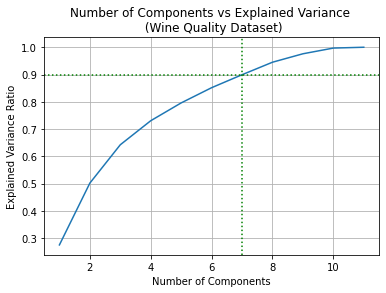

In [192]:
run_pca(x_train_sc)

In [193]:
def run_pca_plot_eigen_values(x_train):
    n = x_train_sc.shape[1]
    data = []
    BARS_TO_SHOW = 10
    
    pca = PCA(n_components=n)
    pca.fit(x_train)
    
    variance = pca.explained_variance_ratio_
    variance = np.round(variance, decimals=3) * 100
    print(variance)
    
    x_labels = range(1, n+1)
    y_values = variance
    
    bars = plt.bar(x_labels[:BARS_TO_SHOW], y_values[:BARS_TO_SHOW], width=0.5)
    
    plt.title("Principal Component vs Explained Variance \n (Breast Cancer Dataset)")
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio") 
    
    plt.xticks(x_labels[:BARS_TO_SHOW])
    plt.savefig('images/wq/2.1 Eigen Values.png')
    plt.show()
    
#     var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

[27.5 22.7 14.1  8.8  6.5  5.6  4.8  4.6  3.1  2.1  0.3]


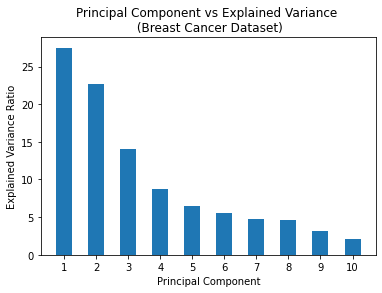

In [194]:
run_pca_plot_eigen_values(x_train_sc)

## 2.2) ICA

In [199]:
def run_ica(x_train):
    """
    Run ICA from n_components 1 to N and get average  kurtosis
    """
    n = x_train_sc.shape[1]
    data = []
    
    for num in range(1, n+1):    
        transformer = ICA(n_components=num, random_state=1)
        x_transformed = transformer.fit_transform(x_train)

        x_transformed = pd.DataFrame(x_transformed)
        kurtosis = x_transformed.kurtosis(axis=0)
        kurtosis_mean = kurtosis.abs().mean()
        
        data.append(kurtosis_mean)
        print(kurtosis_mean)
        

    plt.title("Number of Components vs Average Kurtosis \n(Wine Quality Dataset)")
    plt.xlabel("Number of Components")
    plt.ylabel("Average Kurtosis")
    plt.plot(range(1, n+1), data)
    plt.grid()
    
#     plt.axvline(24, linestyle="dotted", color='g')
    
    plt.savefig('images/wq/2.2 Kurtosis.png')
    plt.show()

0.37056679025399886
1.1954083898038619
1.8689116109030401
2.3973172615721414
8.565674740729445
7.290774146118138
7.110938904885758
12.847039762315067
12.475882330768473
12.042498426263423
22.0319014210163


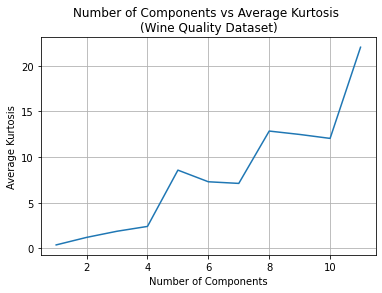

In [200]:
run_ica(x_train_sc)

In [201]:
def run_ica_2(x_train):
    """
    Run ICA for N n_components kurtosis for each component
    """
    n = x_train_sc.shape[1]  
    transformer = ICA(n_components=n, random_state=1)
    x_transformed = transformer.fit_transform(x_train)
    x_transformed = pd.DataFrame(x_transformed)    
    kurtosis = x_transformed.kurtosis(axis=0)
    print(kurtosis)
    kurtosis_abs = kurtosis.abs()
        
    data = []
    for i, k in enumerate(kurtosis_abs):
        data.append([f"IC{i+1}", k])
    
    p = pd.DataFrame(data, columns=["IC", "Kurtosis"])
    
    # get only top 10 IC    
    p.sort_values(by="Kurtosis", ascending=False, inplace=True)
    
    x_labels = p["IC"][:10]
    y_values = p["Kurtosis"][:10]    
    
    plt.title("Average Kurtosis per Component \n (Wine Quality Dataset)")
    plt.ylabel("Average Kurtosis") 
    plt.bar(x_labels, y_values)
    plt.savefig('images/wq/2.2 Kurtosis per IC.png')
    plt.show()
    


0       3.274032
1      -0.712282
2       4.879616
3      11.591912
4       0.734924
5      85.346077
6       1.332165
7     124.957181
8       3.404727
9       5.853307
10     -0.264693
dtype: float64


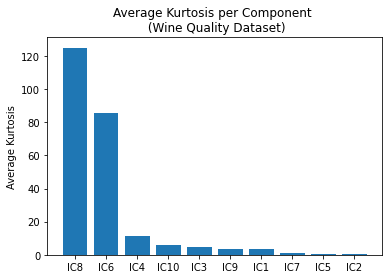

In [202]:
run_ica_2(x_train_sc)

## 2.3 RCA (Randomized Projection)

In [208]:
def run_rp(x_train):
    """
    random projection
    """

    n = x_train_sc.shape[1]
    
    # Run 1
    data = []
    for num in range(1, n+1):
        transformer = RP.GaussianRandomProjection(n_components=num, random_state=0)
        x_transformed = transformer.fit_transform(x_train)
        
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = x_transformed.dot(inverse_data)
        
        error = MSE(x_train, reconstructed_data)
        
        data.append([num, error])
        
        print(f"{num} error={error}")
       
    # Run 2
    data_2 = []
    for num in range(1, n+1):
        transformer = RP.GaussianRandomProjection(n_components=num, random_state=10)
        x_transformed = transformer.fit_transform(x_train)
        
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = x_transformed.dot(inverse_data)
        
        error = MSE(x_train, reconstructed_data)
        
        data_2.append([num, error])
        
    # Run 3
    data_3 = []
    for num in range(1, n+1):
        transformer = RP.GaussianRandomProjection(n_components=num, random_state=20)
        x_transformed = transformer.fit_transform(x_train)
        
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = x_transformed.dot(inverse_data)
        
        error = MSE(x_train, reconstructed_data)
        
        data_3.append([num, error])
        
    # Run 4
    data_4 = []
    for num in range(1, n+1):
        transformer = RP.GaussianRandomProjection(n_components=num, random_state=40)
        x_transformed = transformer.fit_transform(x_train)
        
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = x_transformed.dot(inverse_data)
        
        error = MSE(x_train, reconstructed_data)
        
        data_4.append([num, error])
        
    # Run 5
    data_5 = []
    for num in range(1, n+1):
        transformer = RP.GaussianRandomProjection(n_components=num, random_state=50)
        x_transformed = transformer.fit_transform(x_train)
        
        inverse_data = np.linalg.pinv(transformer.components_.T)
        reconstructed_data = x_transformed.dot(inverse_data)
        
        error = MSE(x_train, reconstructed_data)
        
        data_5.append([num, error])
    
    df = pd.DataFrame(data, columns=["Features", "Reconstruction Error (MSE)"])
    df_2 = pd.DataFrame(data_2, columns=["Features", "Reconstruction Error (MSE)"])
    df_3 = pd.DataFrame(data_3, columns=["Features", "Reconstruction Error (MSE)"])
    df_4 = pd.DataFrame(data_4, columns=["Features", "Reconstruction Error (MSE)"])
    df_5 = pd.DataFrame(data_5, columns=["Features", "Reconstruction Error (MSE)"])
      
    plt.title("Number of Components vs Reconstruction Error \n (Wine Quality Dataset)")
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Error (MSE)") 
    plt.plot(df["Features"], df["Reconstruction Error (MSE)"], label="random_state=1")
    plt.plot(df_2["Features"], df_2["Reconstruction Error (MSE)"], label="random_state=2")
    plt.plot(df_3["Features"], df_3["Reconstruction Error (MSE)"], label="random_state=3")
    plt.plot(df_4["Features"], df_4["Reconstruction Error (MSE)"], label="random_state=4")
    plt.plot(df_5["Features"], df_5["Reconstruction Error (MSE)"], label="random_state=5")
    
    # Error line
    plt.axhline(0.0905110, linestyle="dotted", color='g')
    plt.axvline(10, linestyle="dotted", color='g')
    
    plt.grid()
    plt.legend()
    plt.savefig('images/wq/2.3 rp reconst error.png')
    plt.show()

1 error=0.9051103990806371
2 error=0.8343490943706869
3 error=0.7459090174541213
4 error=0.6556517176208975
5 error=0.5578937657524237
6 error=0.4667667183675663
7 error=0.3685048994941997
8 error=0.24721949979945385
9 error=0.1425628705741677
10 error=0.06856661861618497
11 error=6.93861574949794e-30


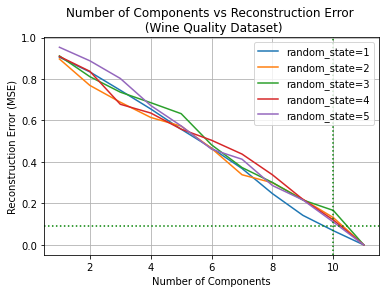

In [209]:
run_rp(x_train_sc)

## 2.4 NCA (Neighborhood Components Analysis)

In [210]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html

# Neighborhood Components Analysis (NCA) tries to find a feature space 
# such that a stochastic nearest neighbor algorithm will give the best accuracy. 
# Like LDA, it is a supervised method.

# One can see that NCA enforces a clustering of the data that is visually meaningful 

In [211]:
def run_nca_knn(x_train_sc, y_train):
    
    n = x_train_sc.shape[1]
    data = []
    
    KNN_NEIGHBORS = 26
    knn = KNeighborsClassifier(n_neighbors=KNN_NEIGHBORS)
    
    for num in range(2, n+1):
        nca_model = NCA(n_components=num, random_state=0)
        x_transformed = nca_model.fit_transform(x_train_sc, y_train)
        
        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(x_transformed, y_train)
        
        # Compute the nearest neighbor accuracy on the embedded test set
        knn_acc = knn.score(nca_model.transform(x_train_sc), y_train)
        
        print(f"{num} KNN Accuracy={knn_acc}")
        data.append([num, knn_acc])
        
    df = pd.DataFrame(data, columns=["Features", "KNN Accuracy"])

    plt.title("Number of Components vs KNN Accuracy \n (Wine Quality Dataset)")
    plt.xlabel("Number of Components")
    plt.ylabel("KNN Accuracy") 
    plt.plot(df["Features"], df["KNN Accuracy"])

    plt.axvline(10, linestyle="dotted", color='g')
    
    plt.grid()
    plt.savefig('images/wq/2.4 nca knn acc.png')
    plt.show()

2 KNN Accuracy=0.6084279391956898
3 KNN Accuracy=0.6167019434289013
4 KNN Accuracy=0.6165095247258033
5 KNN Accuracy=0.6259380411776024
6 KNN Accuracy=0.6193958052722724
7 KNN Accuracy=0.6224745045218395
8 KNN Accuracy=0.6253607850683086
9 KNN Accuracy=0.627477390802386
10 KNN Accuracy=0.636905907254185
11 KNN Accuracy=0.637098325957283


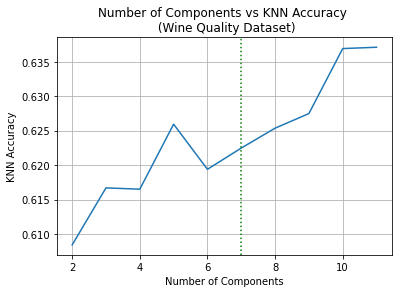

In [212]:
run_nca_knn(x_train_sc, y_train)

In [215]:
# plt.title("Number of Components vs KNN Accuracy \n (Wine Quality Dataset)")
# plt.xlabel("Number of Components")
# plt.ylabel("KNN Accuracy") 
# plt.plot([2,3,4,5,6,7,8,9,10, 11], [
#     0.608427939195,
#     0.616701943428901,
#     0.616509524725803,
#     0.62593804117,
#     0.61939580527227,
#     0.622474504521,
#     0.62536078506830,
#     0.627477390802,
#     0.63690590725,
#     0.637098325957
# ])

# plt.axvline(10, linestyle="dotted", color='g')
    
# plt.grid()
# plt.savefig('images/wq/2.4 nca knn acc.png')
# plt.show()

# 3) DR -> Clustering

- 3.1) PCA -> K-means
- 3.2) PCA -> EM

- 3.3) ICA -> K-means
- 3.4) ICA -> EM

- 3.5) RP -> K-means
- 3.6) RP -> EM

- 3.7) NCA -> K-means
- 3.8) NCA -> EM

## 3.1) PCA -> K-means

In [216]:
def pca_kmeans_sil_score(x_train_sc):
    # Apply PCA
    pca = PCA(n_components = 7)
    x_transformed = pca.fit_transform(x_train_sc)
    x_transformed = pd.DataFrame(x_transformed)

    # Apply Kmeans on PCA x_transformed dataset
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        km = KMeans(n, random_state=0)
        km = km.fit(x_transformed)
        labels = km.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    pca_kmeans_silhouette_score_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    
    return pca_kmeans_silhouette_score_df

In [217]:
pca_kmeans_sil_df = pca_kmeans_sil_score(x_train_sc)

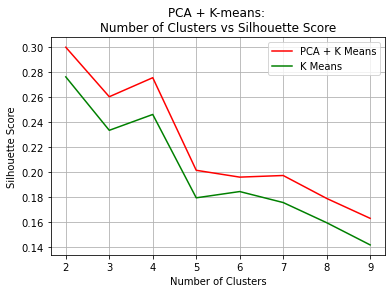

In [218]:
plt.title("PCA + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_kmeans_sil_df["Clusters"], pca_kmeans_sil_df["Silhouette Score"], color='r', label='PCA + K Means')
plt.plot(kmeans_sil_df["Clusters"], kmeans_sil_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.1 pca kmeans sil.png')
plt.show()

## 3.2) PCA -> EM

In [219]:
def pca_em_silhouette_score(x_train_sc):
    pca = PCA(n_components = 7)
    x_transformed = pca.fit_transform(x_train_sc)
    x_transformed = pd.DataFrame(x_transformed)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    pca_em_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    
    return pca_em_sil_df

In [220]:
pca_em_sil_df = pca_em_silhouette_score(x_train_sc)

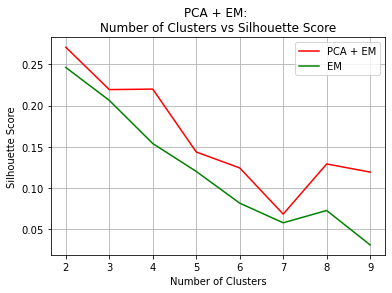

In [221]:
plt.title("PCA + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_em_sil_df["Clusters"], pca_em_sil_df["Silhouette Score"], color='r', label='PCA + EM')
plt.plot(em_sil_df["Clusters"], em_sil_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.2 pca em sil.png')
plt.show()

In [222]:
def pca_em_bic_score(x_train_sc):
    pca = PCA(n_components = 7)
    x_transformed = pca.fit_transform(x_train_sc)
    x_transformed = pd.DataFrame(x_transformed)
    
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        bic = gmm.bic(x_transformed)

        data.append([n, bic])

    pca_em_bic_df = pd.DataFrame(data, columns=["Clusters", "BIC Score"])
    
    return pca_em_bic_df

In [223]:
pca_em_bic_df = pca_em_bic_score(x_train_sc)

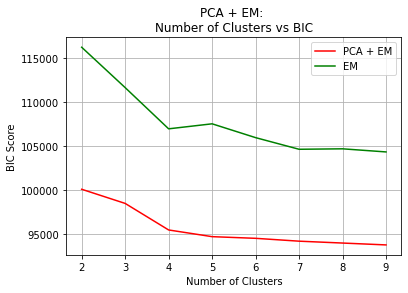

In [224]:
plt.title("PCA + EM: \nNumber of Clusters vs BIC")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score") 

plt.plot(pca_em_bic_df["Clusters"], pca_em_bic_df["BIC Score"], color='r', label='PCA + EM')
plt.plot(em_bic_df["Clusters"], em_bic_df["BIC Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.2 pca em BIC.png')
plt.show()

## 3.3) ICA -> K-means

In [225]:
def ica_kmeans_sil_score(x_train_sc):
    transformer = ICA(n_components=11, random_state=1)
    x_transformed = transformer.fit_transform(x_train_sc)

    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        km = KMeans(n, random_state=0)
        km = km.fit(x_transformed)
        labels = km.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    ica_kmeans_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    
    return ica_kmeans_sil_df

In [226]:
ica_kmeans_sil_df = ica_kmeans_sil_score(x_train_sc)

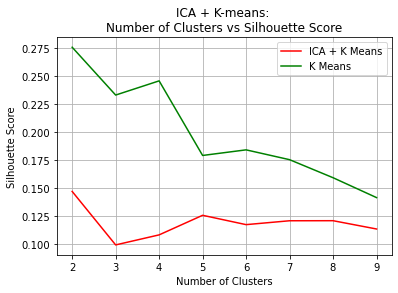

In [227]:
plt.title("ICA + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(ica_kmeans_sil_df["Clusters"], ica_kmeans_sil_df["Silhouette Score"], color='r', label='ICA + K Means')
plt.plot(kmeans_sil_df["Clusters"], kmeans_sil_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.3 ica kmeans sil.png')
plt.show()

## 3.4) ICA -> EM

In [229]:
def ica_em_sil_score(x_train_sc):
    transformer = ICA(n_components=11, random_state=1)
    x_transformed = transformer.fit_transform(x_train_sc)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    ica_em_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    
    return ica_em_sil_df

In [230]:
ica_em_sil_df = ica_em_sil_score(x_train_sc)

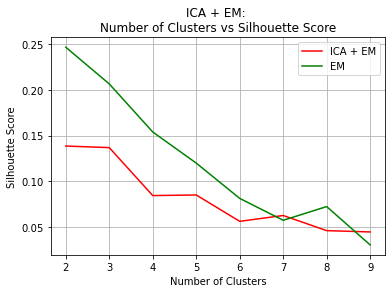

In [231]:
plt.title("ICA + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(ica_em_sil_df["Clusters"], ica_em_sil_df["Silhouette Score"], color='r', label='ICA + EM')
plt.plot(em_sil_df["Clusters"], em_sil_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.4 ica em sil.png')
plt.show()

In [232]:
def ica_em_bic_score(x_train_sc):
    transformer = ICA(n_components=11, random_state=1)
    x_transformed = transformer.fit_transform(x_train_sc)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        bic = gmm.bic(x_transformed)

        data.append([n, bic])

    ica_em_bic_df = pd.DataFrame(data, columns=["Clusters", "BIC Score"])
    
    return ica_em_bic_df

In [233]:
ica_em_bic_df = ica_em_bic_score(x_train_sc)

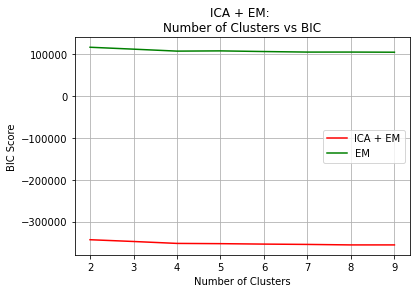

In [234]:
plt.title("ICA + EM: \nNumber of Clusters vs BIC")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score") 

plt.plot(ica_em_bic_df["Clusters"], ica_em_bic_df["BIC Score"], color='r', label='ICA + EM')
plt.plot(em_bic_df["Clusters"], em_bic_df["BIC Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.4 ica em BIC.png')
plt.show()

## 3.5) RP -> K-means

In [235]:
def rp_kmeans_sil_score(x_train_sc):
    transformer = RP.GaussianRandomProjection(n_components=10, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc)

    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        km = KMeans(n, random_state=0)
        km = km.fit(x_transformed)
        labels = km.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    rp_kmeans_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    return rp_kmeans_sil_df

In [236]:
rp_kmeans_sil_df = rp_kmeans_sil_score(x_train_sc)

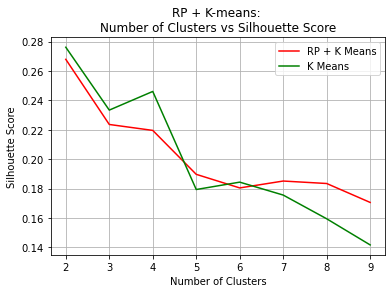

In [237]:
plt.title("RP + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(rp_kmeans_sil_df["Clusters"], rp_kmeans_sil_df["Silhouette Score"], color='r', label='RP + K Means')
plt.plot(kmeans_sil_df["Clusters"], kmeans_sil_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.5 rp kmeans sil.png')
plt.show()

## 3.6) RP -> EM

In [238]:
def rp_em_sil_score(x_train_sc):
    transformer = RP.GaussianRandomProjection(n_components=10, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    rp_em_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    return rp_em_sil_df

In [239]:
rp_em_sil_df = rp_em_sil_score(x_train_sc)

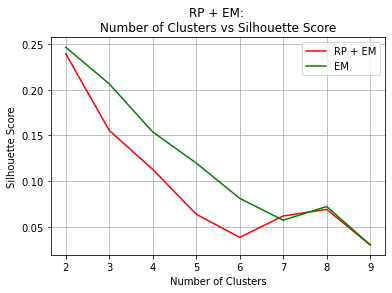

In [240]:
plt.title("RP + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(rp_em_sil_df["Clusters"], rp_em_sil_df["Silhouette Score"], color='r', label='RP + EM')
plt.plot(em_sil_df["Clusters"], em_sil_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.6 rp em sil.png')
plt.show()

In [241]:
def rp_em_bic_score(x_train_sc):
    transformer = RP.GaussianRandomProjection(n_components=10, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        bic = gmm.bic(x_transformed)
    
        data.append([n, bic])

    rp_em_bic_df = pd.DataFrame(data, columns=["Clusters", "BIC Score"])
    return rp_em_bic_df

In [242]:
rp_em_bic_df = rp_em_bic_score(x_train_sc)

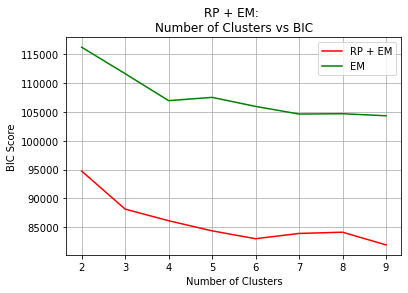

In [243]:
plt.title("RP + EM: \nNumber of Clusters vs BIC")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score") 

plt.plot(rp_em_bic_df["Clusters"], rp_em_bic_df["BIC Score"], color='r', label='RP + EM')
plt.plot(em_bic_df["Clusters"], em_bic_df["BIC Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.6 rp kmeans bic.png')
plt.show()

## 3.7) NCA -> K-means

In [244]:
def nca_kmeans_sil_score(x_train_sc):
    transformer = NCA(n_components=10, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc, y_train)
    
    print(x_transformed.shape)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        km = KMeans(n, random_state=0)
        km = km.fit(x_transformed)
        labels = km.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    nca_kmeans_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    return nca_kmeans_sil_df
    

In [245]:
nca_kmeans_sil_df = nca_kmeans_sil_score(x_train_sc)

(5197, 10)


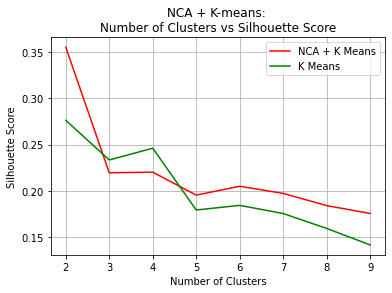

In [246]:
plt.title("NCA + K-means: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(nca_kmeans_sil_df["Clusters"], nca_kmeans_sil_df["Silhouette Score"], color='r', label='NCA + K Means')
plt.plot(kmeans_sil_df["Clusters"], kmeans_sil_df["Silhouette Score"], color='g', label='K Means')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.7 nca kmeans sil.png')
plt.show()

## 3.8) NCA -> EM

In [247]:
def nca_em_sil_score(x_train_sc):
    transformer = NCA(n_components=10, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc, y_train)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        sil = silhouette_score(x_transformed, labels, metric='euclidean')

        data.append([n, sil])

    nca_em_sil_df = pd.DataFrame(data, columns=["Clusters", "Silhouette Score"])
    return nca_em_sil_df

In [248]:
nca_em_sil_df = nca_em_sil_score(x_train_sc)

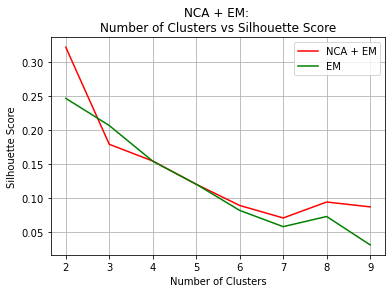

In [249]:
plt.title("NCA + EM: \nNumber of Clusters vs Silhouette Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(nca_em_sil_df["Clusters"], nca_em_sil_df["Silhouette Score"], color='r', label='NCA + EM')
plt.plot(em_sil_df["Clusters"], em_sil_df["Silhouette Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.8 nca em sil.png')
plt.show()

In [250]:
def nca_em_bic_score(x_train_sc):
    transformer = NCA(n_components=10, random_state=0)
    x_transformed = transformer.fit_transform(x_train_sc, y_train)
    
    n_clusters=np.arange(2, 10)
    data=[]

    for n in n_clusters:
        gmm = GaussianMixture(n, random_state=0)
        gmm = gmm.fit(x_transformed)
        labels = gmm.predict(x_transformed)
        bic = gmm.bic(x_transformed)

        data.append([n, bic])

    nca_em_bic_df = pd.DataFrame(data, columns=["Clusters", "BIC Score"])
    return nca_em_bic_df

In [251]:
nca_em_bic_df = nca_em_bic_score(x_train_sc)

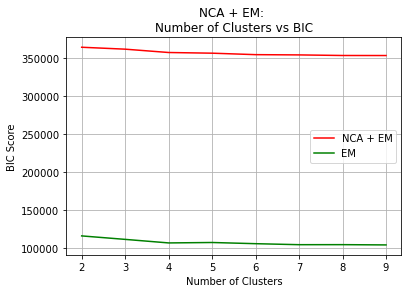

In [252]:
plt.title("NCA + EM: \nNumber of Clusters vs BIC")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score") 

plt.plot(nca_em_bic_df["Clusters"], nca_em_bic_df["BIC Score"], color='r', label='NCA + EM')
plt.plot(em_bic_df["Clusters"], em_bic_df["BIC Score"], color='g', label='EM')

plt.legend()
plt.grid()
# plt.savefig('images/bc/3.8 nca em bic.png')
plt.show()

## 3) All in One

#### All DRs + Kmeans

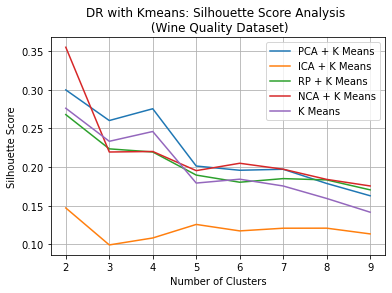

In [253]:
plt.title("DR with Kmeans: Silhouette Score Analysis \n (Wine Quality Dataset)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_kmeans_sil_df["Clusters"], pca_kmeans_sil_df["Silhouette Score"], label='PCA + K Means')
plt.plot(ica_kmeans_sil_df["Clusters"], ica_kmeans_sil_df["Silhouette Score"], label='ICA + K Means')
plt.plot(rp_kmeans_sil_df["Clusters"], rp_kmeans_sil_df["Silhouette Score"], label='RP + K Means')
plt.plot(nca_kmeans_sil_df["Clusters"], nca_kmeans_sil_df["Silhouette Score"], label='NCA + K Means')
plt.plot(kmeans_sil_df["Clusters"], kmeans_sil_df["Silhouette Score"], label='K Means')

plt.legend()
plt.grid()
plt.savefig('images/wq/3.9 all DRs with Kmeans sil.png')
plt.show()

#### All DRs + EM

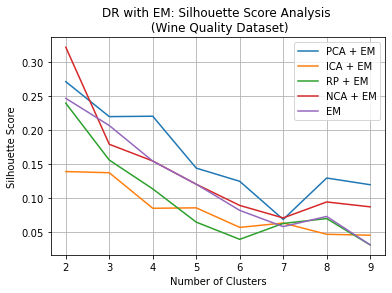

In [254]:
plt.title("DR with EM: Silhouette Score Analysis \n (Wine Quality Dataset)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score") 

plt.plot(pca_em_sil_df["Clusters"], pca_em_sil_df["Silhouette Score"], label='PCA + EM')
plt.plot(ica_em_sil_df["Clusters"], ica_em_sil_df["Silhouette Score"], label='ICA + EM')
plt.plot(rp_em_sil_df["Clusters"], rp_em_sil_df["Silhouette Score"], label='RP + EM')
plt.plot(nca_em_sil_df["Clusters"], nca_em_sil_df["Silhouette Score"], label='NCA + EM')
plt.plot(em_sil_df["Clusters"], em_sil_df["Silhouette Score"], label='EM')

plt.legend()
plt.grid()
plt.savefig('images/wq/3.9 all DRs with EM sil.png')
plt.show()

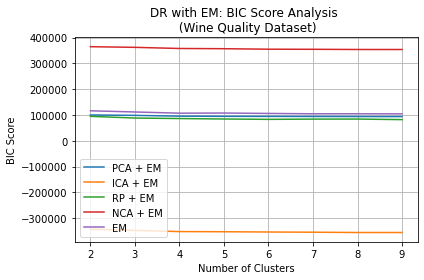

In [255]:
plt.title("DR with EM: BIC Score Analysis \n (Wine Quality Dataset)")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC Score") 

plt.plot(pca_em_bic_df["Clusters"], pca_em_bic_df["BIC Score"], label='PCA + EM')
plt.plot(ica_em_bic_df["Clusters"], ica_em_bic_df["BIC Score"], label='ICA + EM')
plt.plot(rp_em_bic_df["Clusters"], rp_em_bic_df["BIC Score"], label='RP + EM')
plt.plot(nca_em_bic_df["Clusters"], nca_em_bic_df["BIC Score"], label='NCA + EM')
plt.plot(em_bic_df["Clusters"], em_bic_df["BIC Score"], label='EM')

plt.tight_layout()
plt.legend()
plt.grid()
plt.savefig('images/wq/3.9 all DRs with EM BIC.png')
plt.show()